# Anomaly Detection Assignment

In [20]:
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Data loading

Train and Test sets can be found in the `Resources` folder. You can choose to visualize your data all at once, in windows, or only considering a subset of sensors to detect which ones would prove most useful to your analysis.
An example of such a visualization can be found in the following cell.

In [21]:
train_file_path = 'lab1_train.csv'
test_file_path = 'lab1_test.csv'

train_data = pd.read_csv(train_file_path, delimiter=',')
test_data = pd.read_csv(test_file_path, delimiter=',')

# Convert Timestamp column to datetime
train_data['Timestamp'] = pd.to_datetime(train_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')
test_data['Timestamp'] = pd.to_datetime(test_data['Timestamp'], format='%d/%m/%Y %I:%M:%S %p')

### Dynamic Time Warping algorithm

Dynamic Time Warping (DTW) is a powerful algorithm employed in time series analysis, particularly in the realm of anomaly detection. This method proves especially valuable when dealing with sequences of data that may exhibit variations in speed, phase, or other temporal distortions. DTW measures the similarity between two sequences by aligning them in a manner that minimizes the total distance between corresponding points. This alignment process allows for the identification of patterns, even when they may be temporally out of sync. In the context of anomaly detection, DTW enables the discovery of contextual anomalies within time series data. Contextual anomalies refer to instances where the temporal behavior of a sequence deviates significantly from the expected or normal patterns.

In [22]:
def dynamic_time_warping(a, b):
    n = a.size
    m = b.size

    matrix = np.full([n,m], 0.0)
    matrix[0,0] = 0

    # START ANSWER
    for i in range(n):
        for j in range(m):
            if i > 0 and j > 0:
                matrix[i,j] = distance(a[i], b[j]) + np.min([
                    matrix[i-1, j],
                    matrix[i, j-1],
                    matrix[i-1, j-1]
                ])
            if i == 0 and j > 0:
                matrix[i,j] = distance(a[i], b[j]) + matrix[i, j-1]
            if i > 0 and j == 0:
                matrix[i,j] = distance(a[i], b[j]) + matrix[i-1, j]
            if i == 0 and j == 0:
                matrix[i,j] = distance(a[i], b[j])
    # END ANSWER
    return np.sqrt(matrix[n-1, m-1])
    

def distance(a,b):

    return (a - b)**2

### Principal Component Analysis


Principal Component Analysis (PCA) is a widely utilized dimensionality reduction technique that plays a pivotal role in anomaly detection, specifically for identifying point outliers within datasets. Below are the two functions that form our PCA algorithm.

The first function involves the computation of principal components, which are orthogonal vectors representing the directions of maximum variance in the dataset. These principal components serve as a new basis for the data, allowing for a more compact and informative representation. By retaining only the top principal components that capture the majority of the variance, PCA effectively reduces the dimensionality of the data while preserving its essential features.

The second function pertains to projecting the original data onto the subspace defined by the selected principal components.



In [23]:
def principal_component_analysis(df, k):
    eigenvectors = np.zeros(shape=(df.shape[1], k))

    # START ANSWER
    cov = np.cov(df.T)
    val, vec = np.linalg.eig(cov)

    index = np.argsort(val)[::-1]
    index = index[:k]
    eigenvectors = vec[:,index]
    # END ANSWER

    return eigenvectors

In [24]:
def apply_principal_component_analysis(df, eigenvectors):
    projected_data = np.zeros(shape=(df.shape[0], eigenvectors.shape[1]))

    # START ANSWER
    for i in range(df.shape[1]):
        mean = np.mean(df.iloc[:,i])
        df.iloc[:,i] = df.iloc[:,i] - mean

    projected_data = df @ eigenvectors
    # END ANSWER

    return pd.DataFrame(projected_data)

## Familiarization

We can see from the data below that there are 4 general types of sensors: discretely and continuously valued, cyclic and acyclic. 

C:\Users\tanat\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


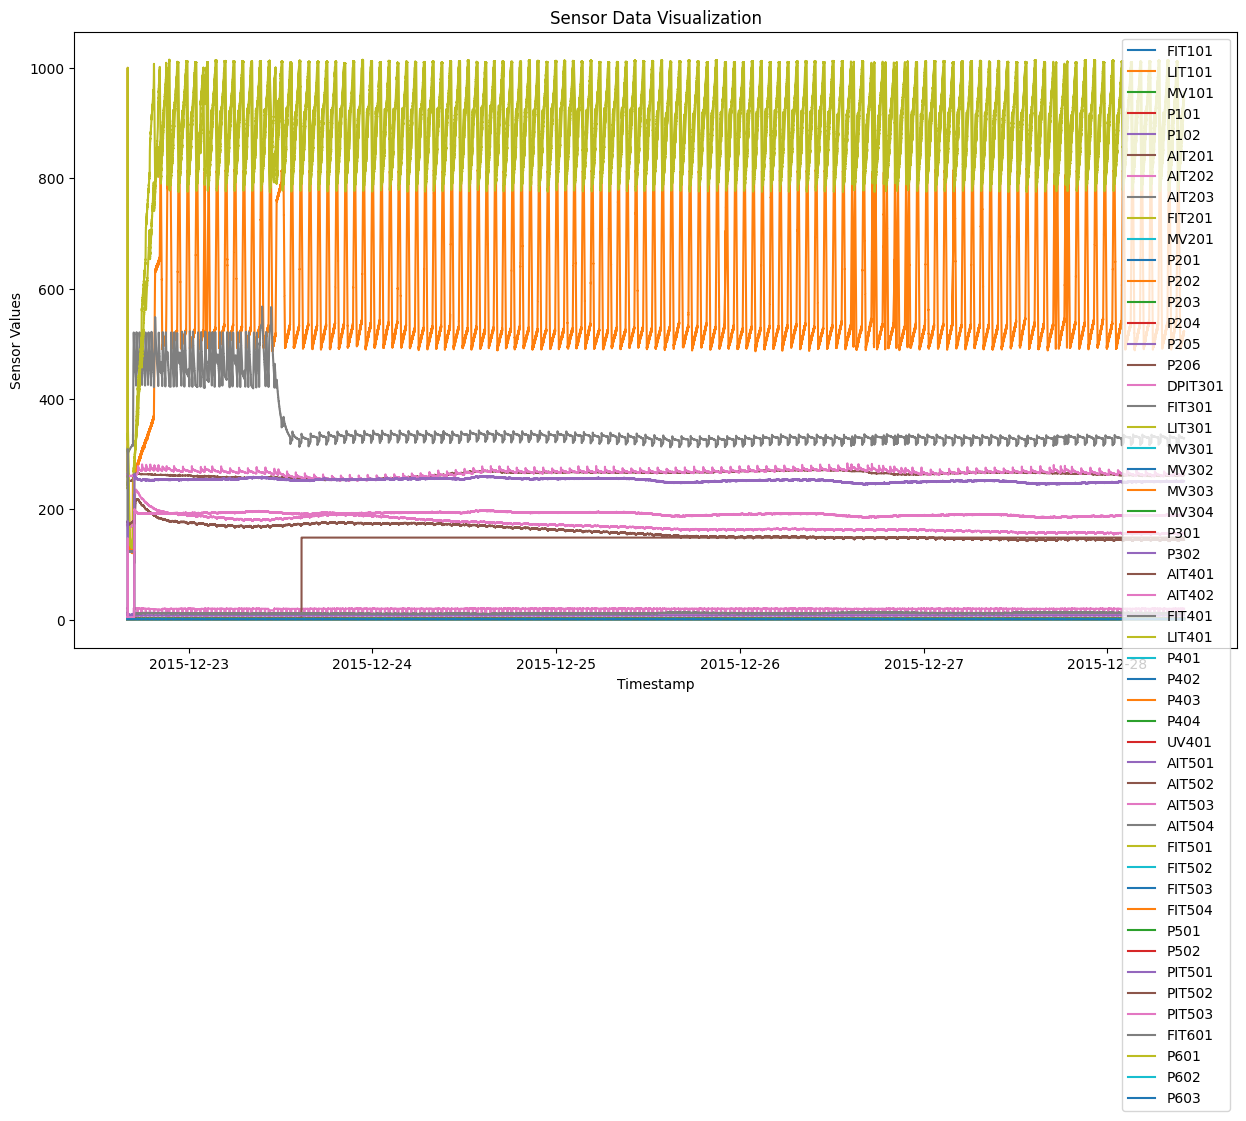

In [25]:
def visualize_sensor_data(df, window=None, sensors=None):
    # If window is None, visualize the entire dataset
    if window is None:
        start_index, end_index = 0, len(df)
    else:
        start_index, end_index = window

    # If sensors is None, select all sensor columns
    if sensors is None:
        sensors = df.columns[1:-1]

    # Plot each sensor in a different color
    plt.figure(figsize=(15, 8))
    for sensor in sensors:
        plt.plot(df['Timestamp'][start_index:end_index], df[sensor][start_index:end_index], label=sensor)

    plt.xlabel('Timestamp')
    plt.ylabel('Sensor Values')
    plt.title('Sensor Data Visualization')
    plt.legend()

    plt.show()


#Visualize all sensor data from the train dataset
visualize_sensor_data(train_data)

### Discretely and Continuously valued sensors

Below is the visualization of two discretely valued sensors: P501, P201. We can see that sensor P501 starts off with a value of 1 and immediately jumps to the value 2, while sensor P201 outputs value 1 for the entirety of the measurement.

What follows is a visualization of a continuously valued sensor, AIT402, which displays continuous values roughly between 140 and 240.

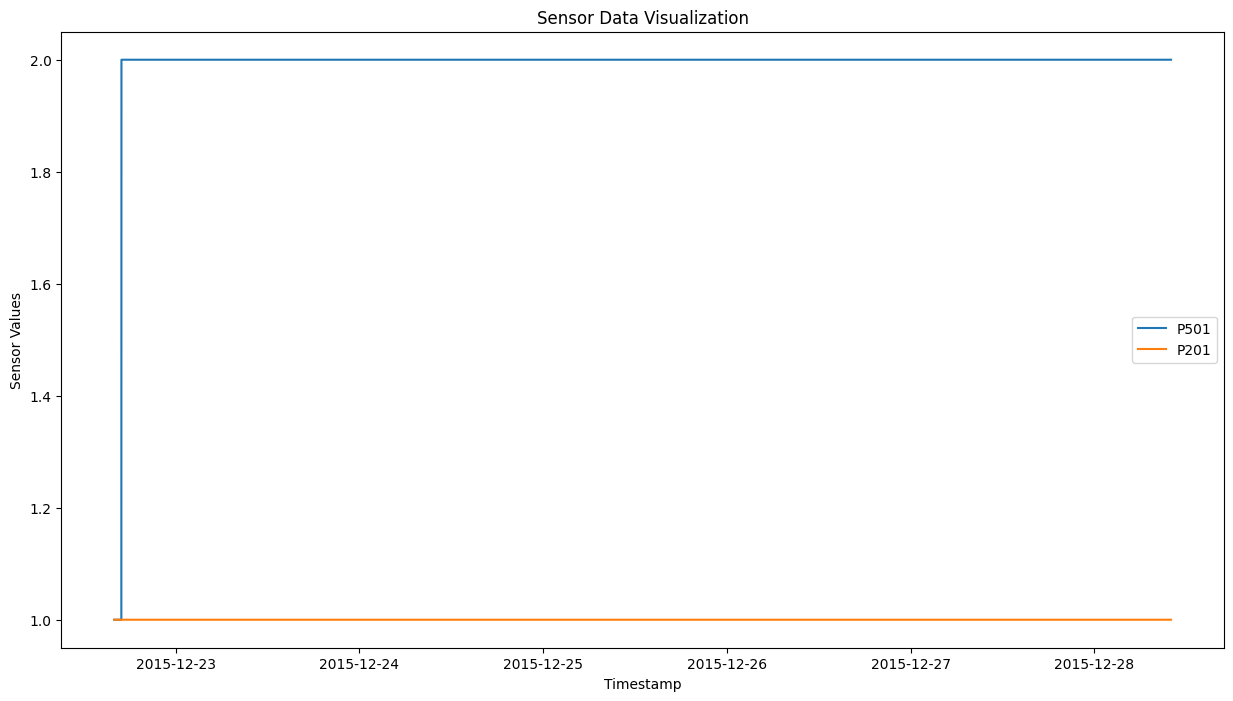

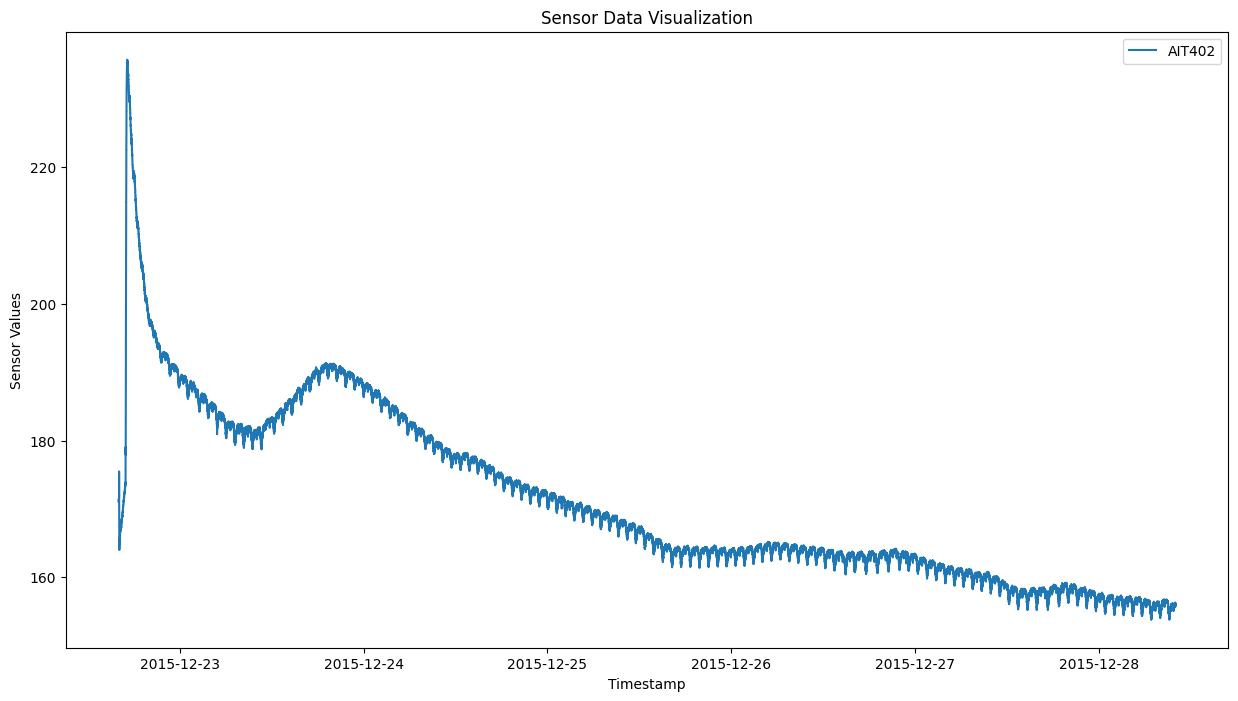

In [26]:
visualize_sensor_data(train_data, sensors=['P501', 'P201'])
visualize_sensor_data(train_data, sensors=['AIT402'])

### Cyclic vs Acyclic

We can clearly see from the plots below that sensors LIT301 and LIT101 are cyclic, displaying periodic behaviour, while sensor AIT503 is acyclic, overall having no discernible pattern over the duration of the measurement.

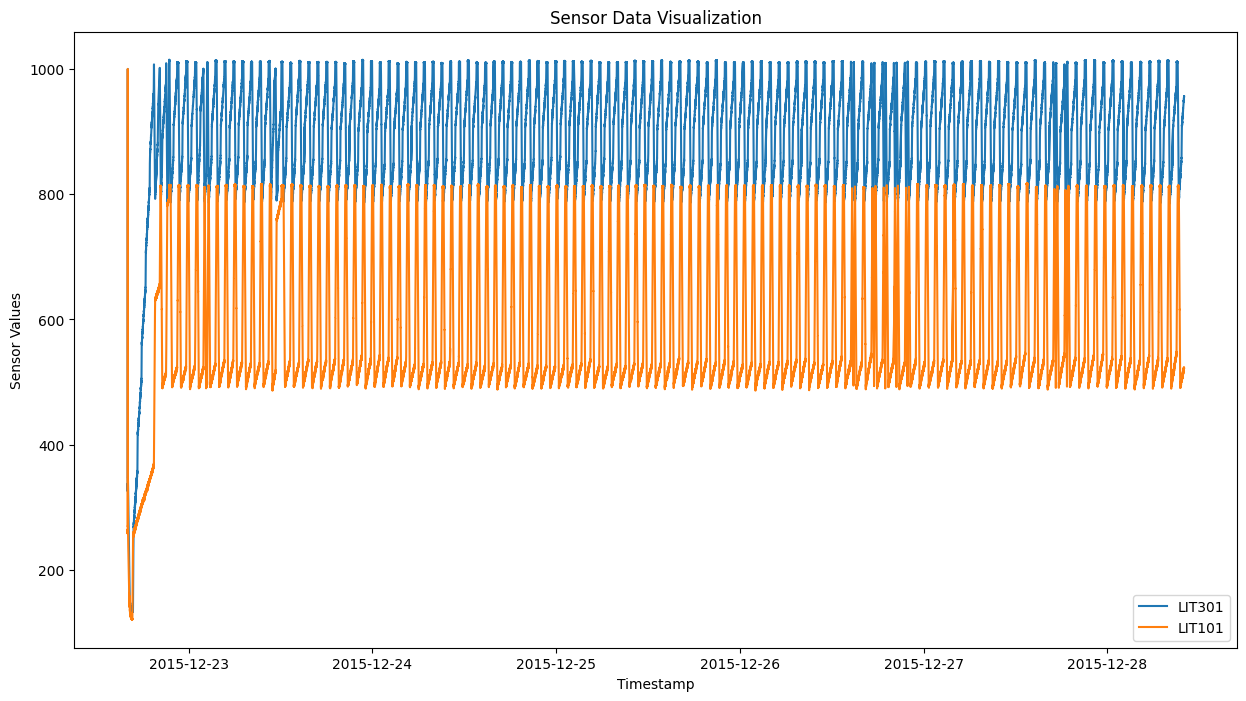

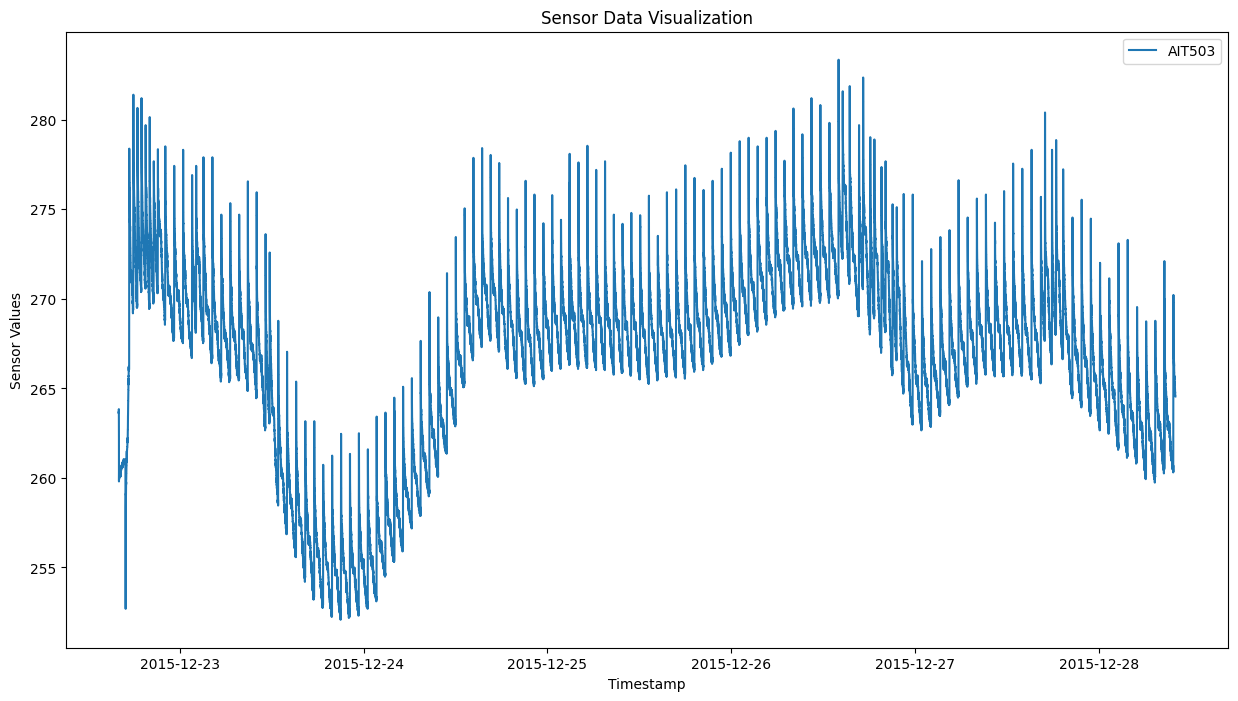

In [27]:
visualize_sensor_data(train_data, sensors=['LIT301', 'LIT101'])
visualize_sensor_data(train_data, sensors=['AIT503'])

### Are the signals correlated?

Some sensors are clearly correlated, such as FIT501 and FIT502, plotted below.

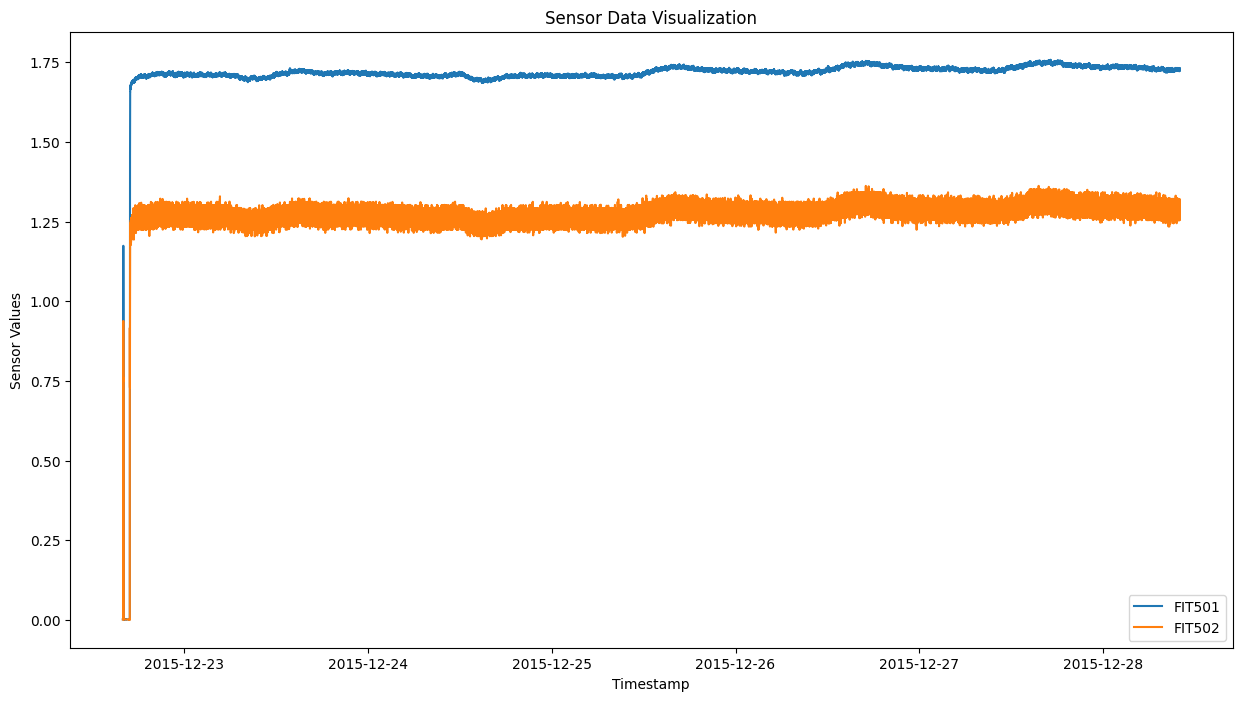

In [28]:
visualize_sensor_data(train_data, sensors=['FIT501', 'FIT502'])

## Dynamic Time Warping

### Sensor selection

Below we print the sensor LIT401 from both the train and test sets. 

Given it is both continuously valued and cyclic, while also observing anomalies in the test set, going forward this will be the sensor we use to perform DTW-based anomaly detection.

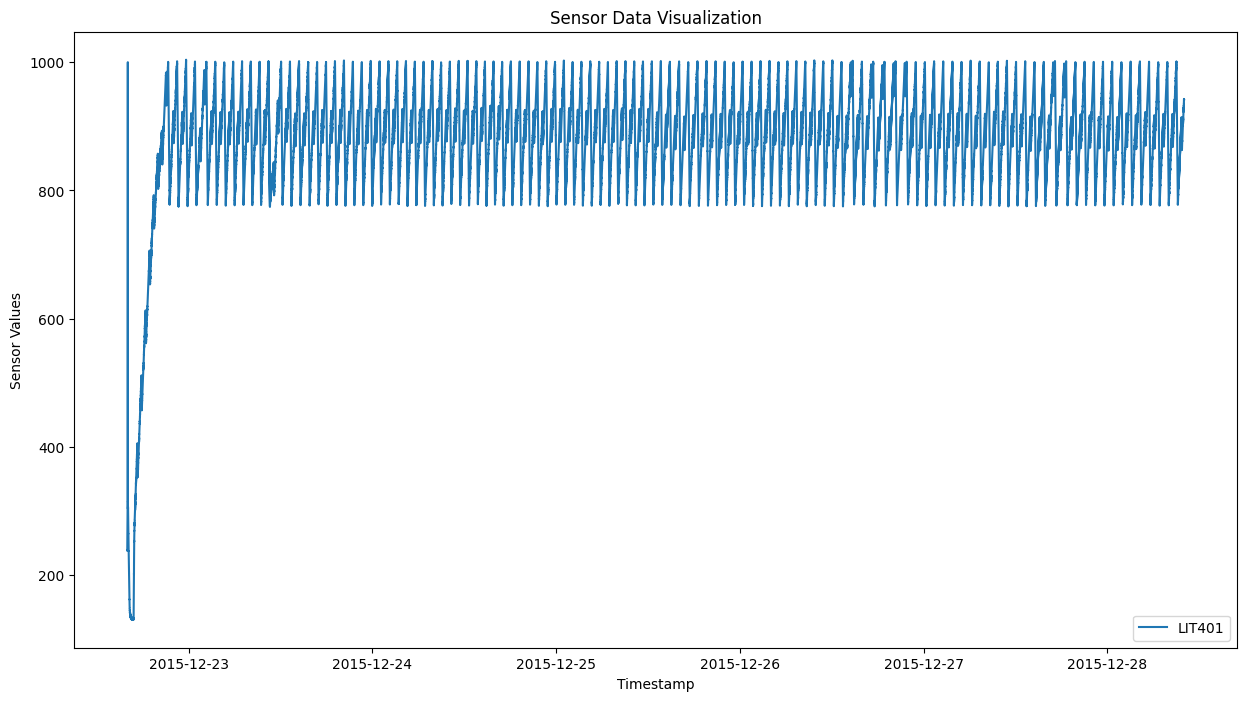

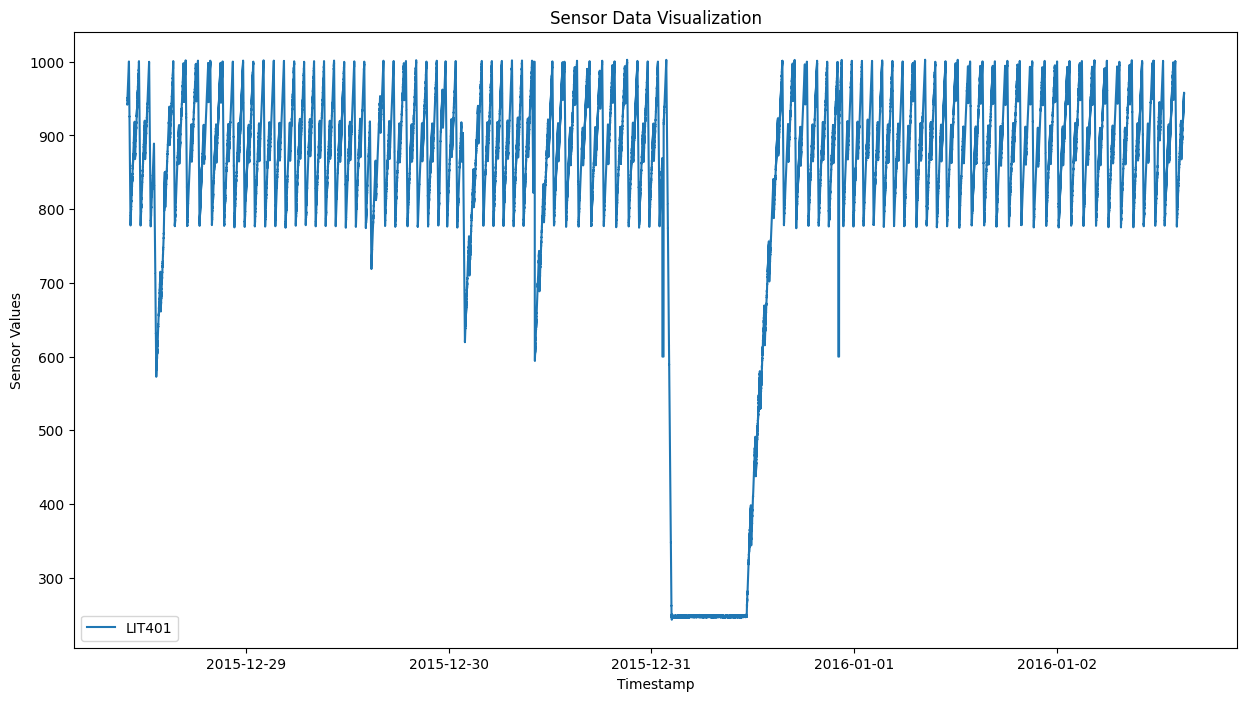

In [29]:
visualize_sensor_data(train_data, sensors=['LIT401'])
visualize_sensor_data(test_data, sensors=['LIT401'])

### Window selection

We must select a set of windows that thoroughly represent our sensor. After careful consideration we have arrived at the following 4 windows for our sensor, which show our sensor in a phase of ascent, descent, regional minimum and regional peak:

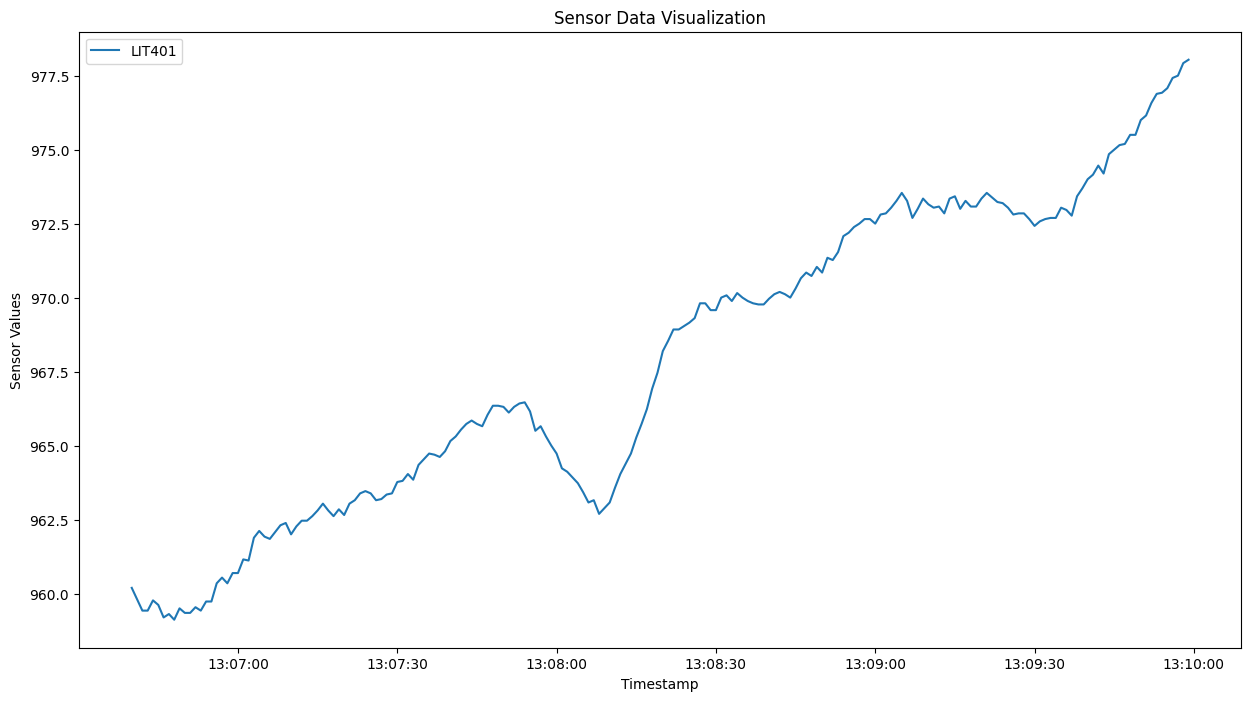

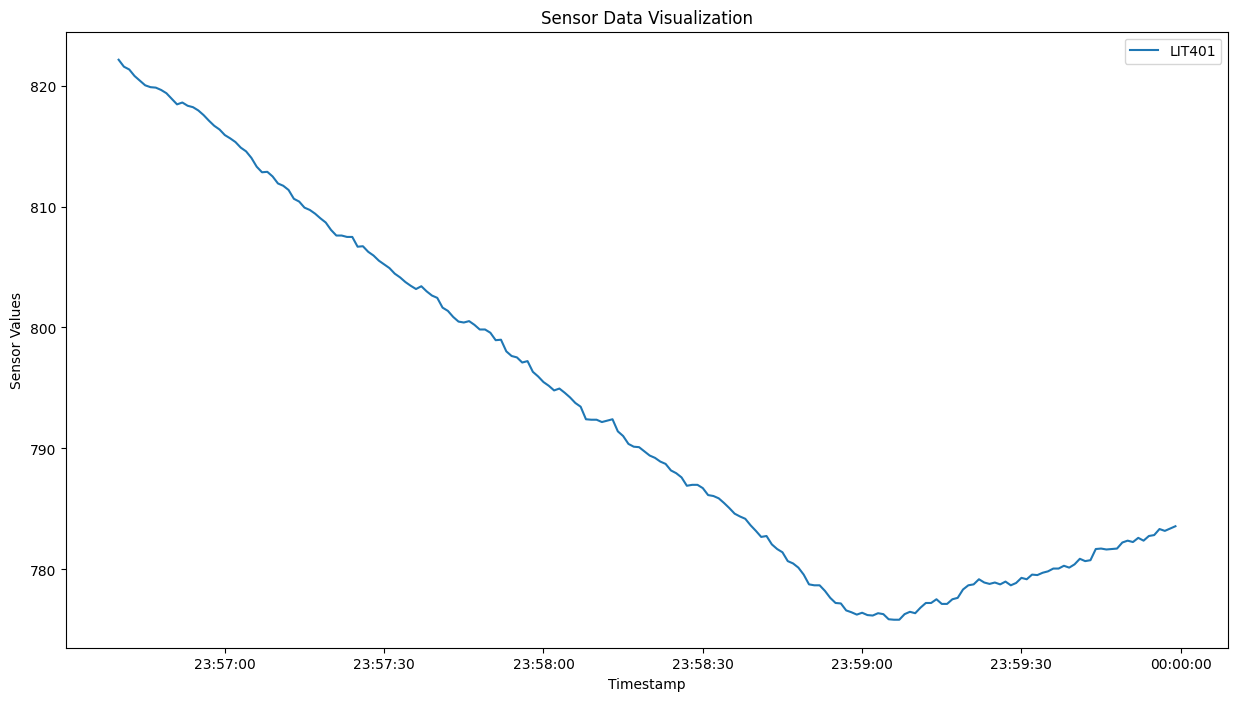

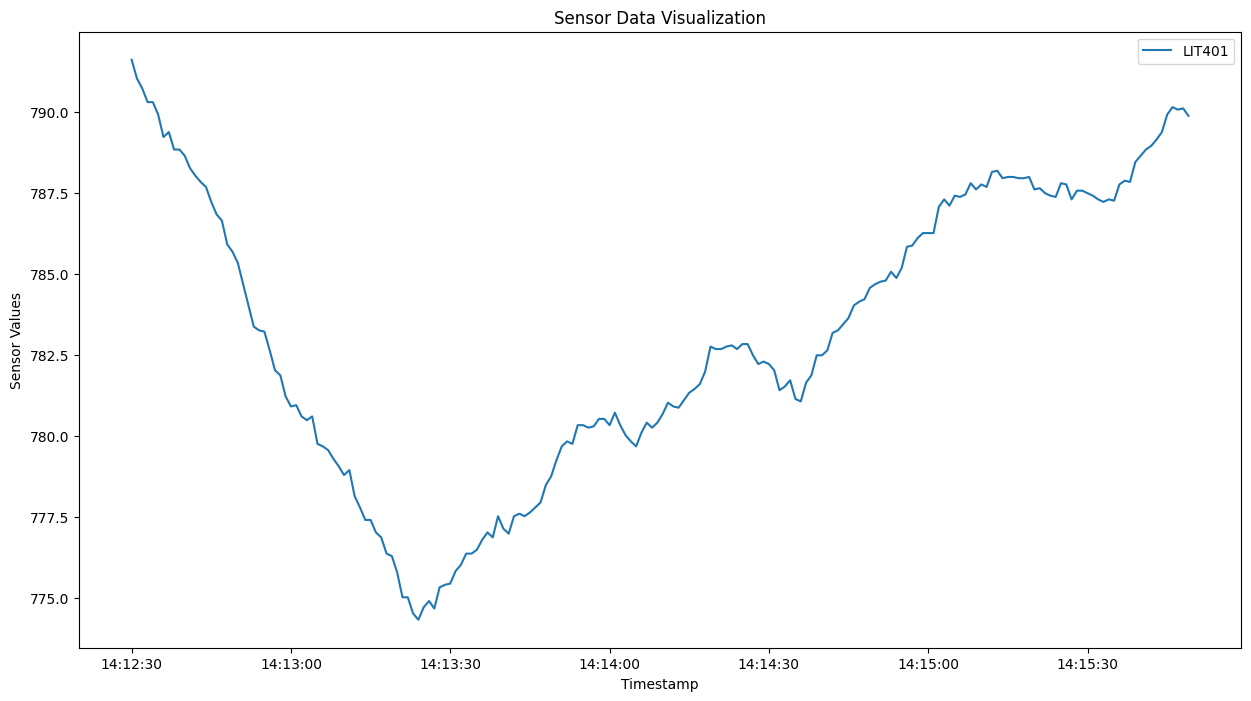

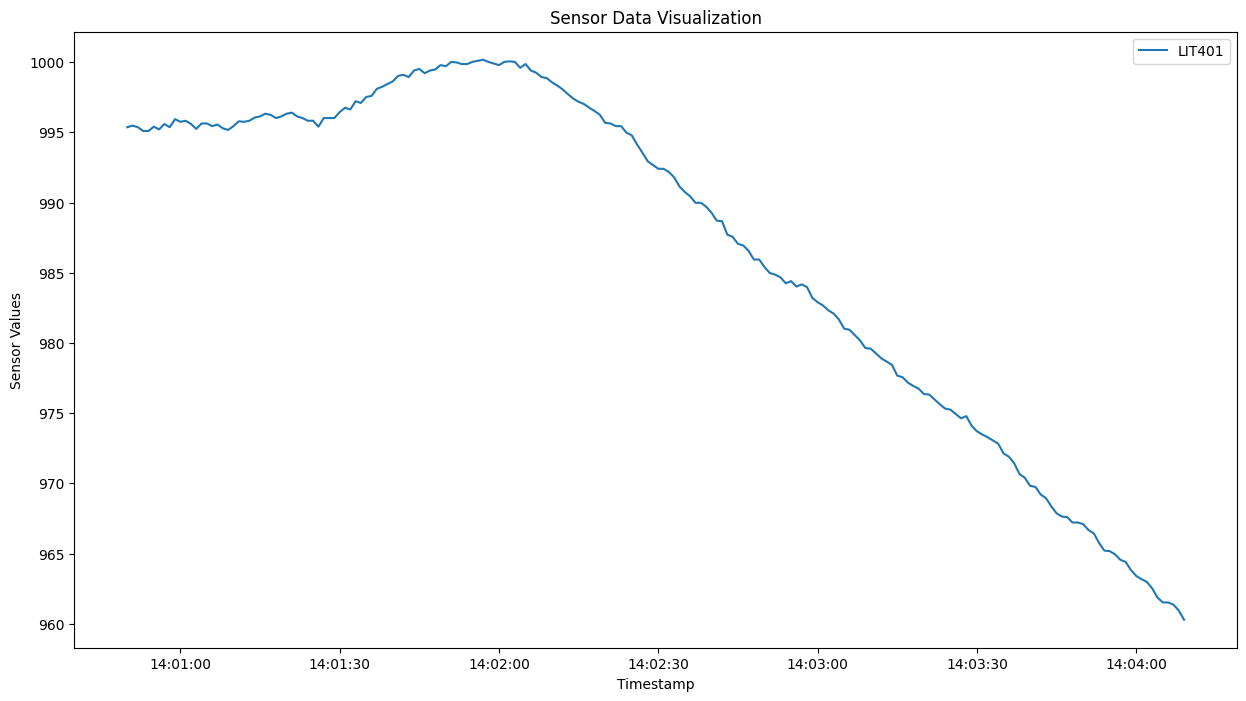

In [30]:
visualize_sensor_data(train_data, window=(76000,76200), sensors=['LIT401'])
visualize_sensor_data(train_data, window=(115000,115200), sensors=['LIT401'])
visualize_sensor_data(test_data, window=(101550,101750), sensors=['LIT401'])
visualize_sensor_data(test_data, window=(100850,101050), sensors=['LIT401'])

### Applying DTW-based anomaly detection

After selecting 4 representative windows from the train dataset, we create sliding windows of 400 points through 100,000 points in the test dataset (out of approximately 500,000). We then perform Dynamic Time Warping using Euclidean Distance on each of the 4 template windows. The results are stored in an array, and the residual is the minimum value of this array. This is done to prevent unfair comparison between windows. For example, if the current window (from the test set) is in a descending phase, such as in the second instance of the template windows, it would be unfair to take into consideration the residual of the comparison with the first template window, which is clearly in an ascending phase.

After experimenting with different windows and sizes, we concluded that a residual of 1500 is the best threshold for this particular sensor. If the residual of the current window is above the threshold, we increment a variable that counts the number of anomalies.

Two aspects were predominantly in our minds when selecting these sizes: performance, but also ensuring good representation of the data and context. Due to performance issues, we also skip over 200 points after each iteration.

(It is recommended not to rerun the cell below due to high processing duration. it is advisable to reduce the number of points traversed when creating the sliding windows in order to improve performance, at the cost of the quality of the evaluation).

We found 19  anomalies


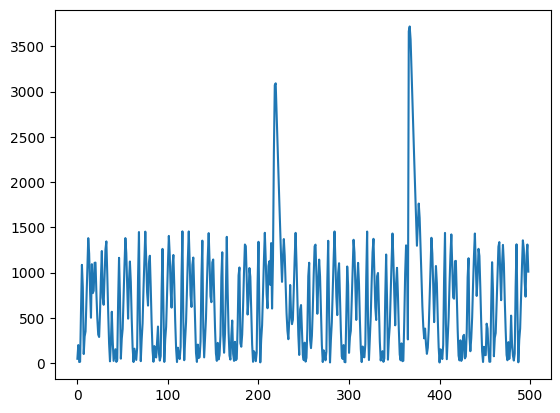

In [31]:
#Selecting sliding windows from the test set
test_sliding_window = np.lib.stride_tricks.sliding_window_view(test_data['LIT401'][100000:200000], 400)

windows = train_data['LIT401'].values

#Initializing the array of residuals and the anomaly counter
res = []
anomalies = 0

#Performing DTW against all 4 template windows selected from the train set
for i in range(0,test_sliding_window.shape[0], 200):
    res.append(np.min(np.array(
        [dynamic_time_warping(test_sliding_window[i], windows[76000:76400]),
        dynamic_time_warping(test_sliding_window[i], windows[115000:115400]),
        dynamic_time_warping(test_sliding_window[i], windows[101550:101950]),
        dynamic_time_warping(test_sliding_window[i], windows[100850:101250])]
    )))
    
    #If the residual is above the threshold, increment the anomaly counter
    if res[-1] > 1500:
        anomalies = anomalies + 1
    
    #Auxiliary for printing progress
    percent = i / test_sliding_window.shape[0] * 100
    print(f'{percent:.2f}%', end='\r')
 
plt.plot(res)
print('We found', anomalies,' anomalies')

## Principal Component Analysis

### Preparing the data

Below we begin performing PCA-based anomaly detection. First, we need to drop the 'Timestamp' and 'Normal/Attack' columns, as we are not interested in these columns affecting the result of our algorithm. Next, we compute the mean and standard deviation of every column (sensor) in our dataset. We next ensure that, in cases where a sensor reads a single value, we change the standard deviation from 0 to 1 to avoid division by 0 (the exact value which replaces the standard deviation does not matter, as in such cases the mean will be equal with the value read by the sensor, so we will divide 0 by our chosen number). 

After normalizing the data, we change the column names into integers from 0 to 50 (this will help with computations later when we recompute the restored dataset after applying PCA)

In [32]:
data = train_data.drop(['Timestamp', 'Normal/Attack'], axis = 1)

mean = np.mean(data, axis = 0)
std = np.std(data, axis = 0)

zero_std_dev_indices = np.where(std == 0)[0]
std.iloc[zero_std_dev_indices] = 1

data = (data - mean) / std
data.rename(columns={old_col: i for i, old_col in enumerate(data.columns)}, inplace=True)

### Performing PCA

Next, we compute the eigenvectors of the largest 10 eigenvalues, and use these to apply PCA to our dataset. We then restore the dataset, thus losing the most prominent point outliers in our dataset.

In [33]:
eigenvectors = principal_component_analysis(data, 10)
pca = apply_principal_component_analysis(data, eigenvectors)

restored_data = pca @ eigenvectors.T

Next, we compute the residuals between our original dataset and our restored dataset.

In [34]:
#Time array (made up of the indices of the rows) to place on the x-axis when plotting the datasets
time = np.arange(len(data))
    
#Function that computes the residuals between two datasets and returns them as an array
def compute_residuals(data, restored_data):
    residuals = np.zeros(len(data))

    for index in range(data.shape[0]):
        residuals[index] = np.mean((data.iloc[index] - restored_data.iloc[index])**2)
    
        percent = index / data.shape[0] * 100
        print(f'{percent:.2f}%', end='\r')
        
    return residuals

residuals = compute_residuals(data, restored_data)

The function below will allow us to visualize the differences between our original dataset and the restored one. It will also help us visualize the residuals. A new function is required due to dropping the 'Timestamp' column, thus not being able to use the provided visualize_sensor_data function.

In [35]:
#Function that plots the given data. The 'time' parameter represents the x-axis, and the threshold is used to create a dotted, horizontal line on the plot to symbolize certain threshold if necessary
def plot_data(data, time, threshold=None):
    
    plt.figure(figsize=(15, 8))
    plt.plot(time, data)
    
    if threshold is not None:
        plt.axhline(y=threshold, color='red', linestyle='--', label='Horizontal Line at y=0.5')
    
    plt.xlabel('Index')
    plt.ylabel('Sensor Values')
    plt.show()
    

Below we plot the original and restored datasets, along with the residuals. We can see that point outliers have been removed. The largest anomalies take place at the beginning if the dataset, which is supported by the high values in the plot of our residuals.

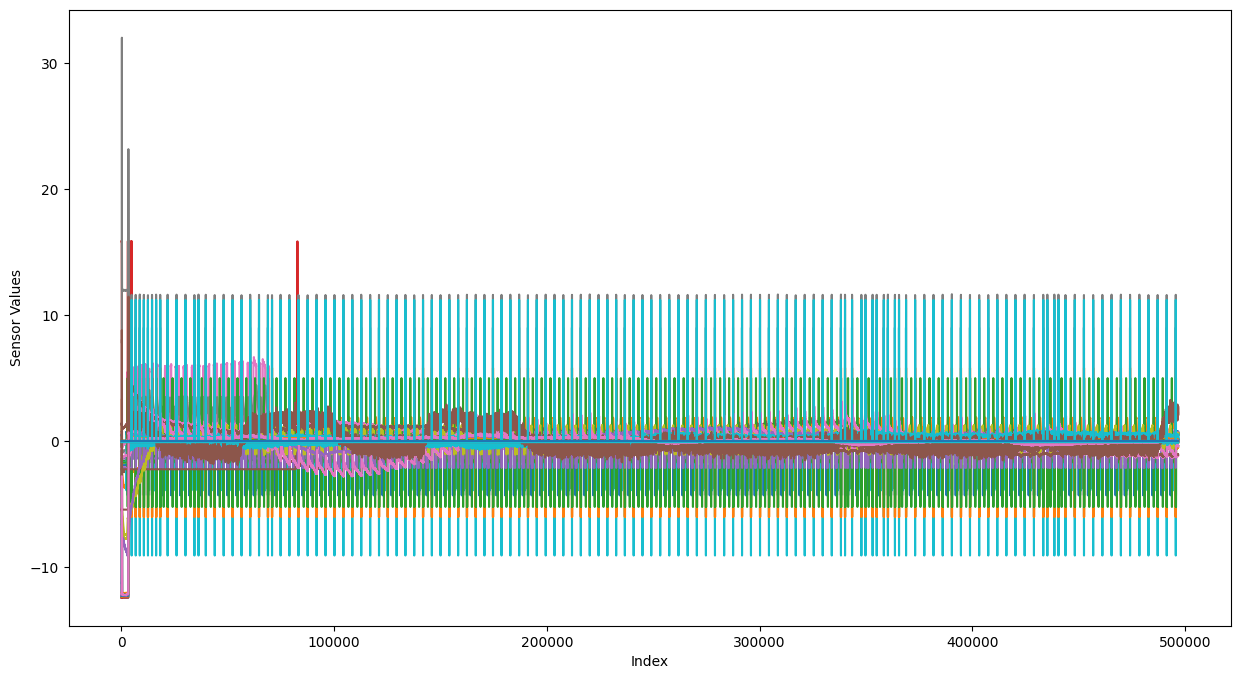

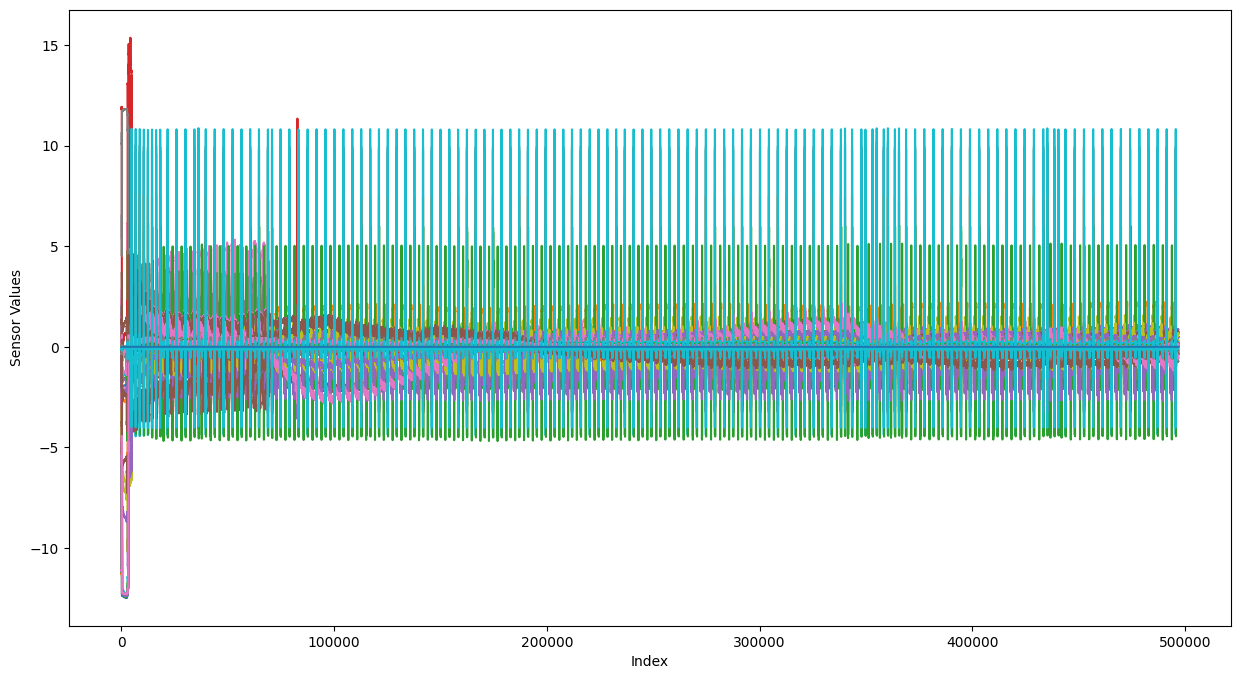

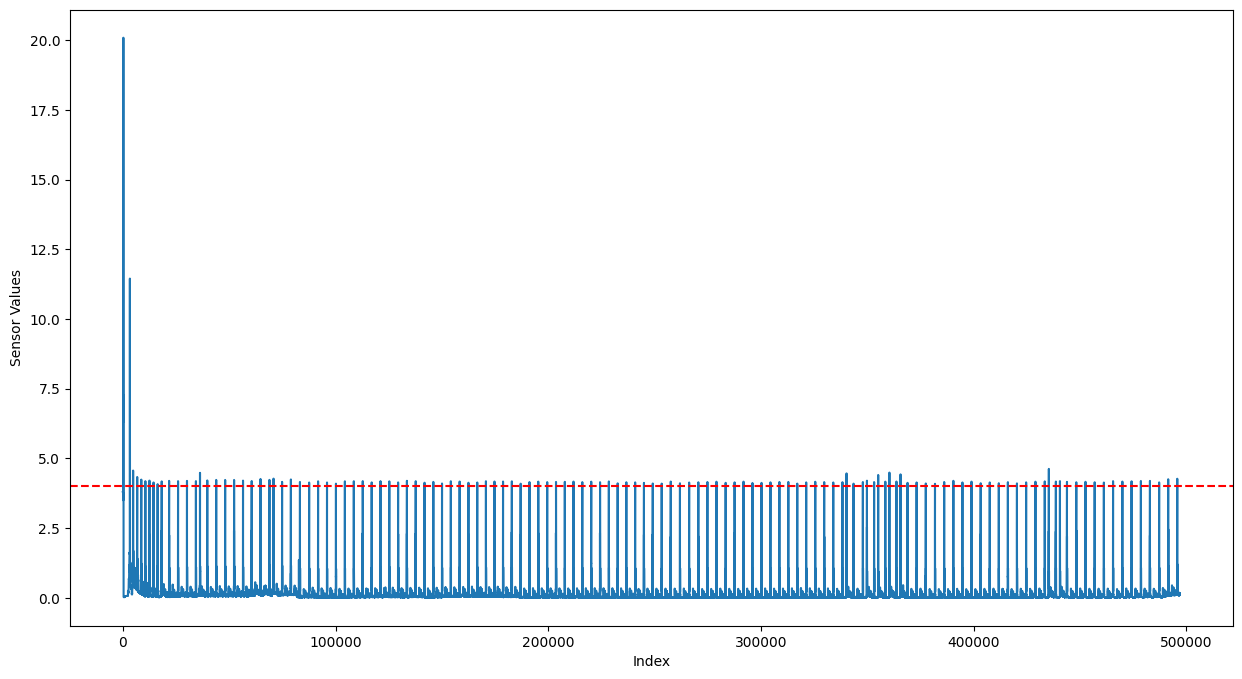

In [36]:
plot_data(data,time)
plot_data(restored_data, time)
plot_data(residuals, time, 4)

We now remove all points with a residual above the threshold and plot the original dataset and the updated one.

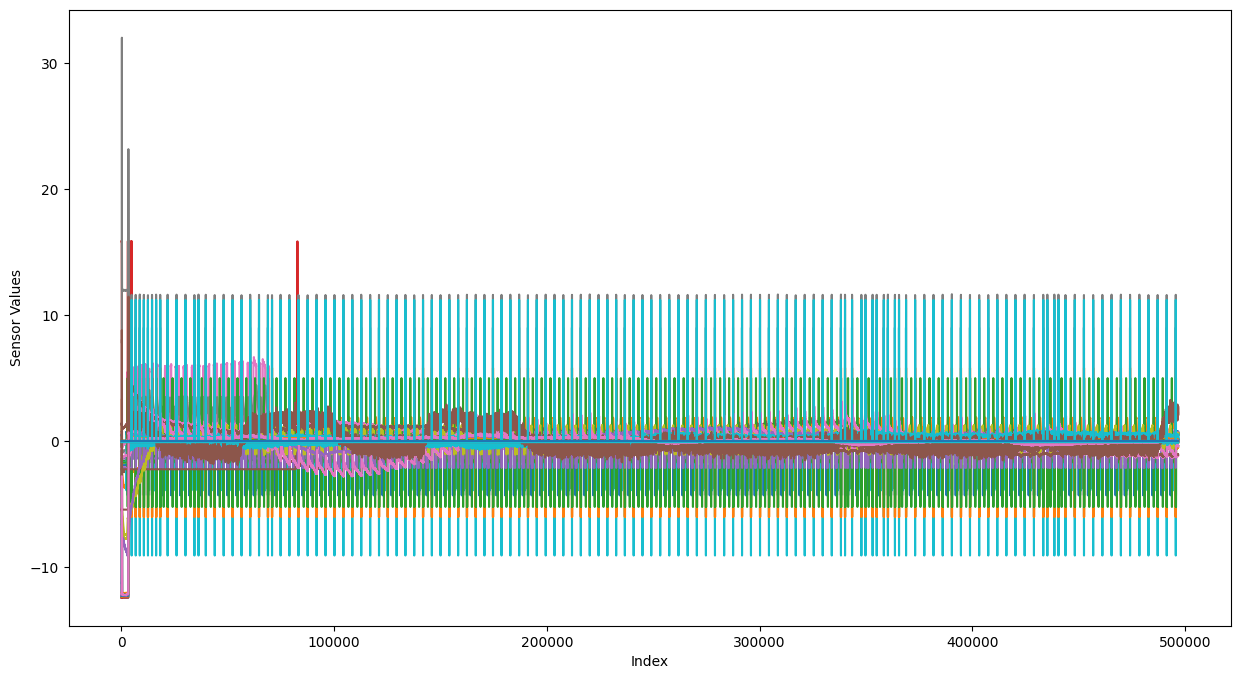

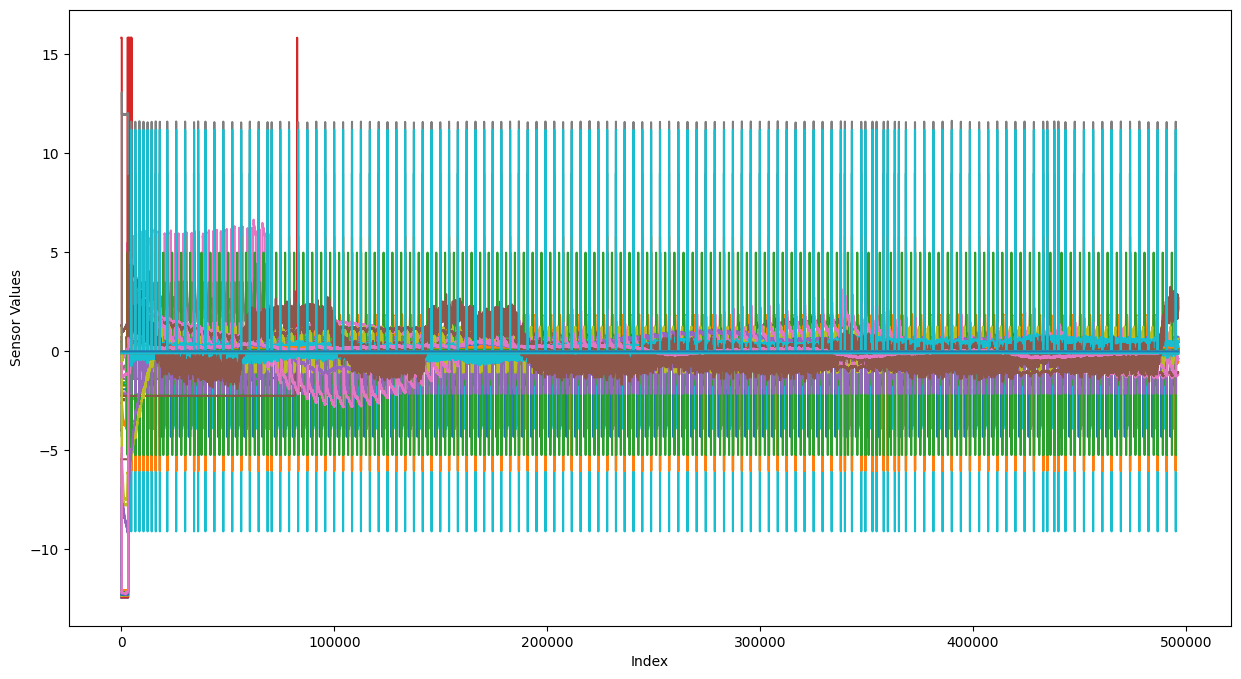

In [37]:
plot_data(data, time)

above_threshold_indices = np.where(residuals >= 4)[0]
data_without_anomalies = data.drop(above_threshold_indices, axis=0)

plot_data(data_without_anomalies, np.arange(len(data_without_anomalies)))

Now that we have removed the outliers from our training data, we continue by processing the test data in the same manner: replace values of 0 in the standard deviation vector to avoid dividing by 0, normalize the data and rename columns.

In [38]:
data_test = test_data.drop(['Timestamp', 'Normal/Attack'], axis=1)

mean_test = np.mean(data_test, axis=0)
std_test= np.std(data_test, axis=0)

zero_std_dev_indices_test = np.where(std_test == 0)[0]
std_test.iloc[zero_std_dev_indices_test] = 1

data_test = (data_test - mean_test) / std_test
data_test.rename(columns={old_col: i for i, old_col in enumerate(data_test.columns)}, inplace=True)

After processing the test data, we compute new eigenvectors using the updated training data (after anomalies have been removed). This is done to ensure we use the best possible eigenvectors to detect anomalies in the test set. After applying PCA to the test set, we proceed to restore the data and compute residuals. We then proceed to visualize the results.

In [39]:
new_eigenvectors = principal_component_analysis(data_without_anomalies, 10)
pca_test = apply_principal_component_analysis(data_test, new_eigenvectors)

restored_data_test = pca_test @ new_eigenvectors.T

In [40]:
time_test = np.arange(len(data_test))
residuals_test = compute_residuals(data_test, restored_data_test)

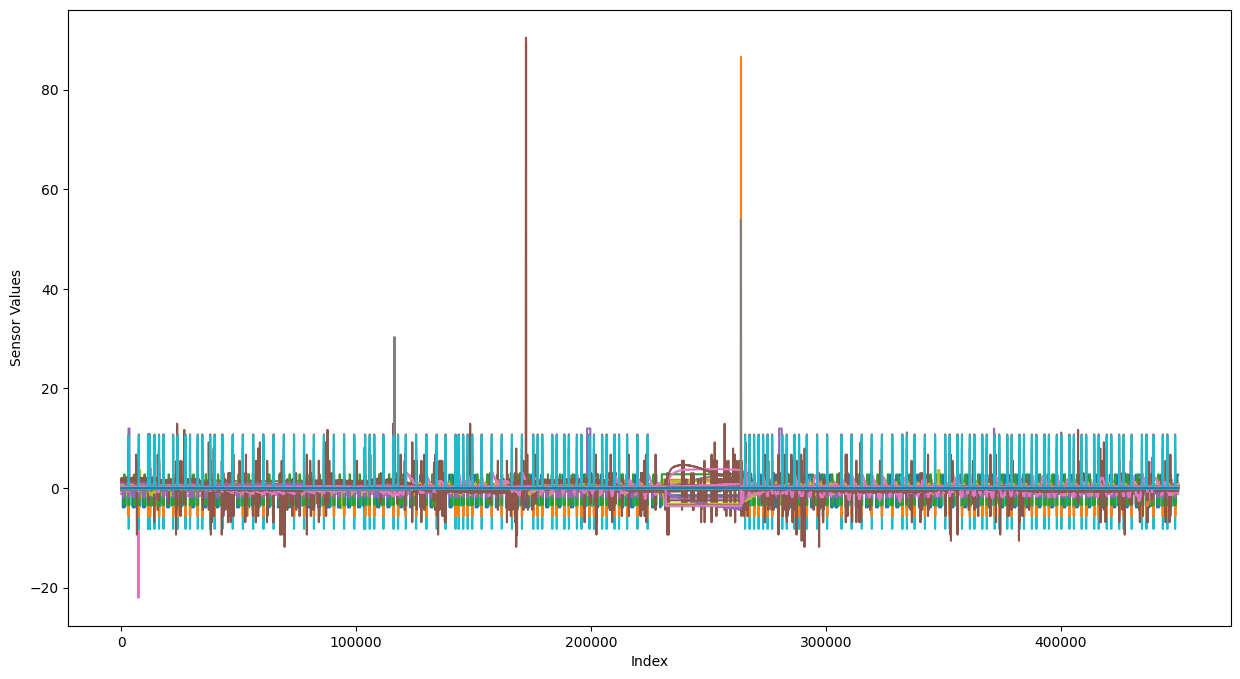

In [41]:
plot_data(data_test,time_test)

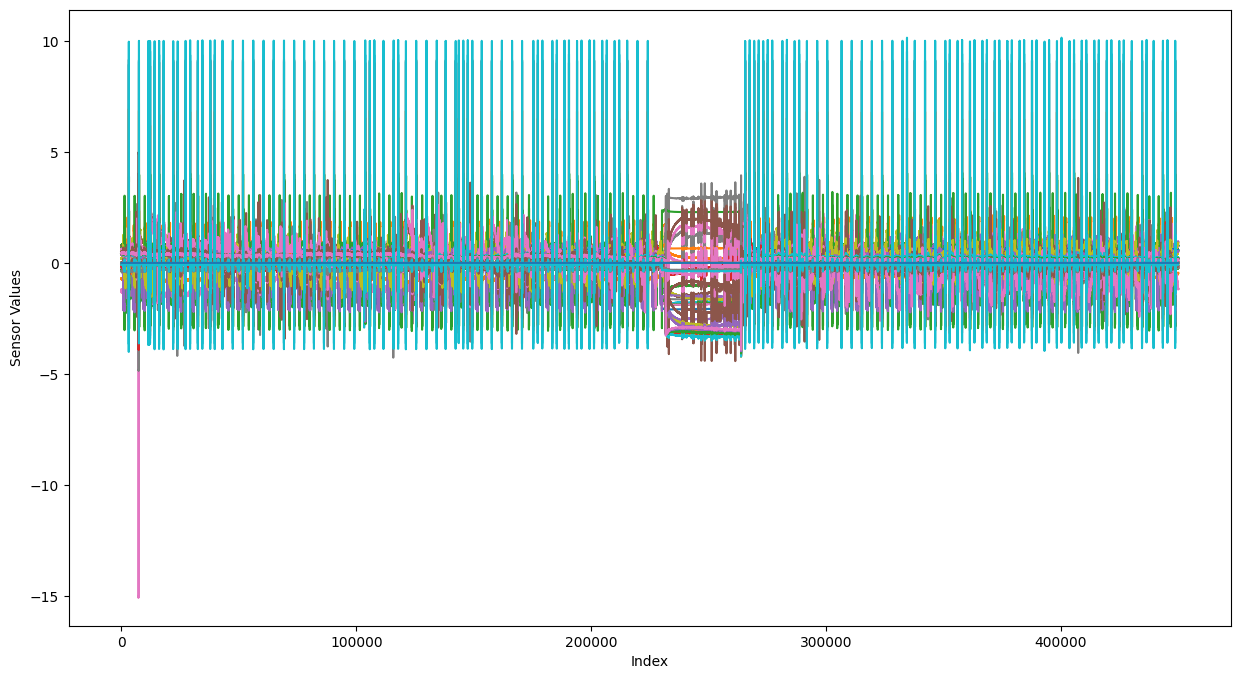

In [42]:
plot_data(restored_data_test, time_test)

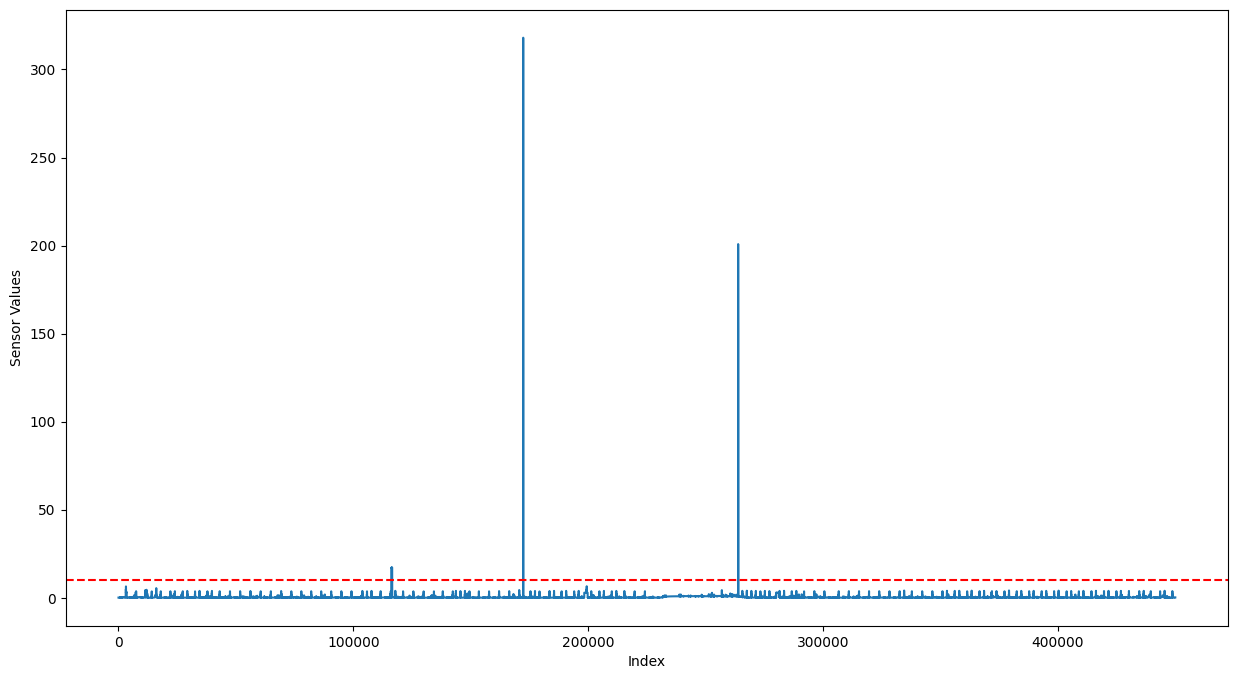

In [43]:
plot_data(residuals_test, time_test, 10)

After removing anomalies above the threshold, we visualize the test data for one last time to check that the anomalies have been removed.

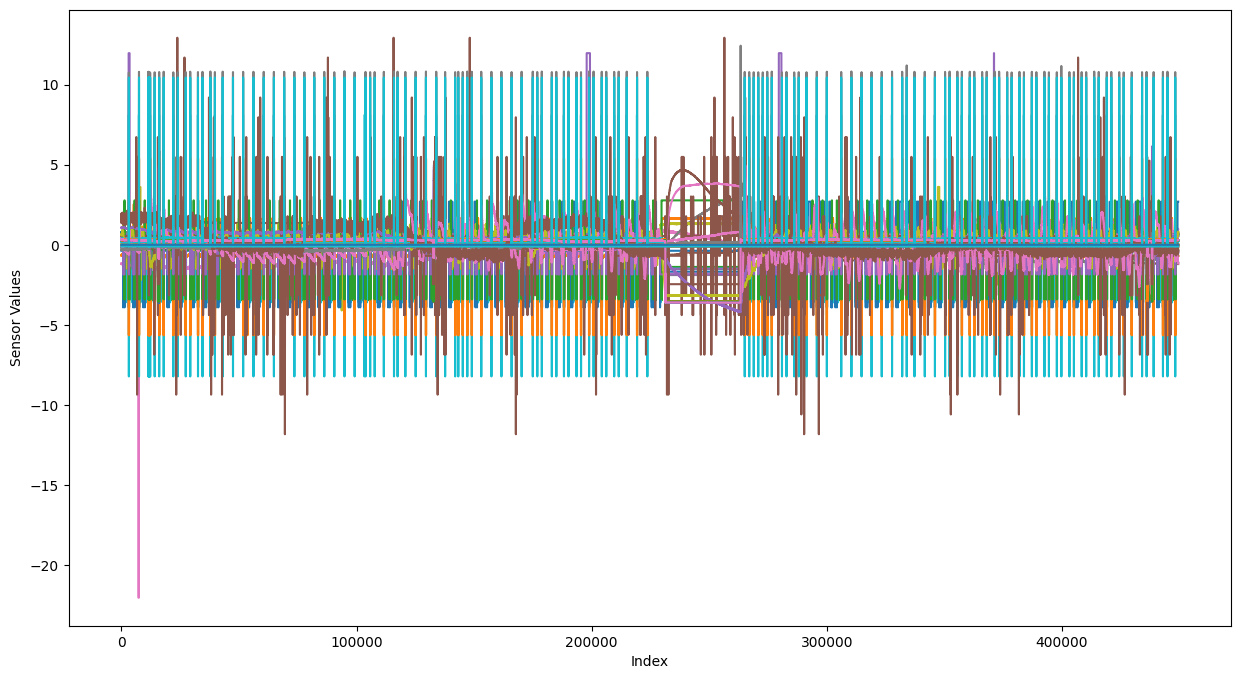

In [44]:
above_threshold_indices_test = np.where(residuals_test >= 10)[0]
data_test_without_anomalies = data_test.drop(above_threshold_indices_test, axis=0)

plot_data(data_test_without_anomalies, np.arange(len(data_test_without_anomalies)))